<a href="https://colab.research.google.com/github/pelinbalci/TF_Custom_Models/blob/main/Multiple_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I analyze the wine dataset and build a model for multiple outputs: is_red (0,1) and quality(float). Different loss function are used for two outputs. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import utils

# Visualize model
from tensorflow.keras.layers import Layer
from tensorflow.python.keras.utils.vis_utils import pydot
from tensorflow.python.keras.utils.vis_utils import plot_model

# Error : Function call stack:train_function
# https://github.com/tensorflow/tensorflow/issues/43174
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Load Data

In [ ]:
# URL of the white wine dataset
URI = './winequality-white.csv'

# load the dataset from the URL
white_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with zeros.
white_df["is_red"] = 0 # YOUR CODE HERE

# keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')

# URL of the red wine dataset
URI = './winequality-red.csv'

# load the dataset from the URL
red_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with ones.
red_df["is_red"] = 1 # YOUR CODE HERE

# keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')

df = pd.concat([red_df, white_df], ignore_index=True)

In [ ]:
white_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,0


In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1


In [ ]:
white_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.0
mean,6.839346,0.280538,0.334332,5.914819,0.045905,34.889169,137.193512,0.993790,3.195458,0.490351,10.589358,5.854835,0.0
std,0.866860,0.103437,0.122446,4.861646,0.023103,17.210021,43.129065,0.002905,0.151546,0.113523,1.217076,0.890683,0.0
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.0
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991620,3.090000,0.410000,9.500000,5.000000,0.0
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,6.000000,0.0
75%,7.300000,0.330000,0.390000,8.900000,0.050000,45.000000,166.000000,0.995710,3.290000,0.550000,11.400000,6.000000,0.0
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000,0.0


In [ ]:
red_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.0
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252,1.0
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578,0.0
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,1.0
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000,1.0
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000,1.0
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000,1.0
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1.0


<AxesSubplot:>

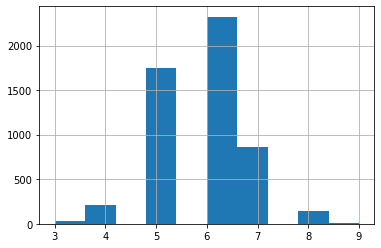

In [ ]:
df.quality.hist(bins=10)

In [ ]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
is_red                  0
dtype: int64

In [ ]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'is_red'],
      dtype='object')

# Outlier Elimination

In [ ]:
df = df[(df['quality'] > 4) & (df['quality'] < 8)]

<AxesSubplot:>

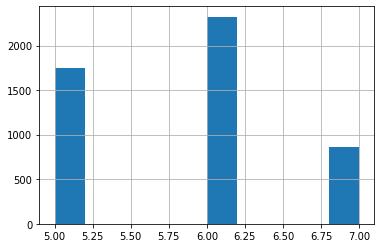

In [ ]:
df.quality.hist(bins=10)

# Train Test Split

In [ ]:
# split df into 80:20 train and test sets
train, test = train_test_split(df, test_size= 0.2, # YOUR CODE HERE
                               random_state = 1)
                               
# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size= 0.2, # YOUR CODE HERE, 
                              random_state = 1)

In [ ]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_red
241,7.5,0.65,0.18,7.0,0.088,27.0,94.0,0.99915,3.38,0.77,9.4,5,1
3856,6.3,0.27,0.29,12.2,0.044,59.0,196.0,0.99782,3.14,0.40,8.8,6,0
4147,8.8,0.27,0.25,5.0,0.024,52.0,99.0,0.99250,2.87,0.49,11.4,5,0
1856,6.4,0.45,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8,5,0
1300,7.2,0.53,0.13,2.0,0.058,18.0,22.0,0.99573,3.21,0.68,9.9,6,1


# Format Output

In [ ]:
def format_target(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [ ]:
train_Y = format_target(train)
val_Y = format_target(val)
test_Y = format_target(test)

In [ ]:
print(train_Y)

(array([5, 6, 5, ..., 6, 5, 5], dtype=int64), array([1, 0, 0, ..., 1, 1, 0], dtype=int64))


# Normalize Data

In [ ]:
train_stats = train.describe().T
print(train_stats.head())
print(train.columns)

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

                   count      mean       std    min    25%    50%    75%  \
fixed acidity     3155.0  7.221616  1.325297  3.800  6.400  7.000  7.700   
volatile acidity  3155.0  0.338929  0.162476  0.080  0.230  0.290  0.400   
citric acid       3155.0  0.321569  0.147970  0.000  0.250  0.310  0.400   
residual sugar    3155.0  5.155911  4.639632  0.600  1.800  2.800  7.650   
chlorides         3155.0  0.056976  0.036802  0.012  0.038  0.047  0.066   

                     max  
fixed acidity     15.600  
volatile acidity   1.240  
citric acid        1.660  
residual sugar    65.800  
chlorides          0.611  
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


In [ ]:
norm_train_X = norm(train)
    
# normalize the val set
norm_val_X = norm(val)
    
# normalize the test set
norm_test_X = norm(test)

# Define Model

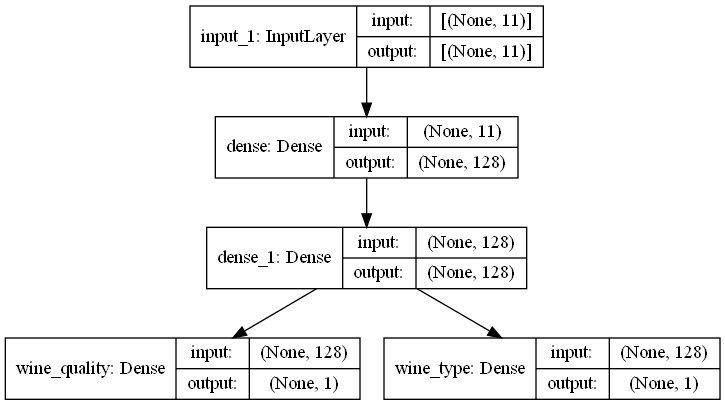

In [ ]:
inputs = tf.keras.layers.Input(shape=(11,))
dense_1 = Dense(128, activation='relu')(inputs)
dense_2 = Dense(128, activation='relu')(dense_1)
wine_quality = Dense(units='1', name='wine_quality')(dense_2)
wine_type = Dense(units='1', activation= 'sigmoid',
                      name='wine_type')(dense_2)

model = Model(inputs=inputs, outputs=[wine_quality, wine_type])

model._layers = [layer for layer in model._layers if isinstance (layer, Layer)]
plot_model(model, show_shapes = True, show_layer_names = True)

In [ ]:
def base_model(inputs):
    
    # connect a Dense layer with 128 neurons and a relu activation
    x = Dense(128, activation='relu')(inputs) # YOUR CODE HERE
    
    # connect another Dense layer with 128 neurons and a relu activation
    x = Dense(128, activation='relu')(x)# YOUR CODE HERE
    return x


def final_model(inputs):
    
    # get the base model
    x = base_model(inputs)

    # connect the output Dense layer for regression
    wine_quality = Dense(units='1', name='wine_quality')(x)

    # connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units='1', activation= 'sigmoid', # YOUR CODE HERE, 
                      name='wine_type')(x)

    # define the model using the input and output layers
    model = Model(inputs=inputs, outputs=[wine_quality, wine_type]) # YOUR CODE HERE, outputs=# YOUR CODE HERE)

    return model

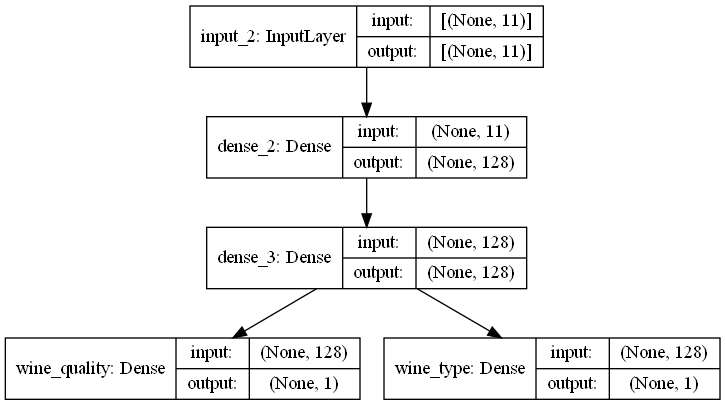

In [ ]:
inputs = tf.keras.layers.Input(shape=(11,))

model = final_model(inputs)
model._layers = [layer for layer in model._layers if isinstance (layer, Layer)]
plot_model(model, show_shapes = True, show_layer_names = True)

In [ ]:

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss = {'wine_type' : "binary_crossentropy", # YOUR CODE HERE,
                      'wine_quality' : 'mse' # YOUR CODE HERE
                     },
              metrics = {'wine_type' : 'accuracy', # YOUR CODE HERE,
                         'wine_quality' : tf.keras.metrics.RootMeanSquaredError() # YOUR CODE HERE
                       }
             )

history = model.fit(norm_train_X, train_Y, # YOUR CODE HERE, # YOUR CODE HERE,
                    epochs = 40, validation_data=(norm_val_X, val_Y)) # YOUR CODE HERE, # YOUR CODE HERE))

Epoch 1/40
99/99 [==============================] - 5s 30ms/step - loss: 27.6801 - wine_quality_loss: 27.1136 - wine_type_loss: 0.5665 - wine_quality_root_mean_squared_error: 5.2021 - wine_type_accuracy: 0.9027 - val_loss: 16.8929 - val_wine_quality_loss: 16.3590 - val_wine_type_loss: 0.5339 - val_wine_quality_root_mean_squared_error: 4.0446 - val_wine_type_accuracy: 0.8302
Epoch 2/40
99/99 [==============================] - 1s 9ms/step - loss: 13.7459 - wine_quality_loss: 13.2322 - wine_type_loss: 0.5137 - wine_quality_root_mean_squared_error: 3.6290 - wine_type_accuracy: 0.8206 - val_loss: 6.1088 - val_wine_quality_loss: 5.6339 - val_wine_type_loss: 0.4749 - val_wine_quality_root_mean_squared_error: 2.3736 - val_wine_type_accuracy: 0.7744
Epoch 3/40
99/99 [==============================] - 1s 9ms/step - loss: 4.7226 - wine_quality_loss: 4.2819 - wine_type_loss: 0.4407 - wine_quality_root_mean_squared_error: 2.0666 - wine_type_accuracy: 0.7872 - val_loss: 2.9873 - val_wine_quality_los

# Evaluate Results

In [ ]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]
 
len(predictions)
print(predictions[0][:10])
print(predictions[1][:10])

[[5.5843687]
 [5.6964173]
 [6.807561 ]
 [5.288986 ]
 [5.679747 ]
 [5.3691697]
 [6.1259103]
 [6.717866 ]
 [6.2605495]
 [5.805866 ]]
[[3.8338038e-03]
 [4.6930986e-04]
 [9.9806482e-01]
 [2.3559557e-02]
 [5.5550802e-03]
 [2.6000370e-04]
 [9.9995232e-01]
 [2.0484913e-03]
 [3.0384425e-02]
 [1.3009401e-03]]


In [ ]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend()
    plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

<ipython-input-24-47bb6e202cb0>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-24-47bb6e202cb0>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


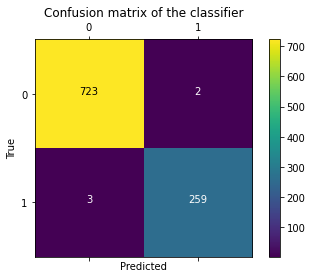

In [ ]:
plot_confusion_matrix(test_Y[1], 
                      np.round(type_pred), 
                      title='Wine Type', 
                      labels = [0, 1])

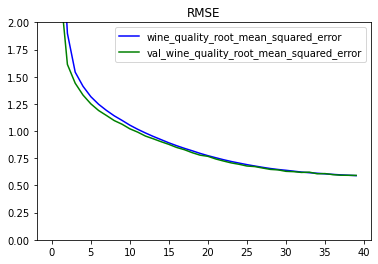

In [ ]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

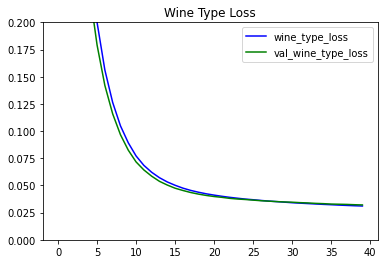

In [ ]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)